In [1]:
!pip install torchvision

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix


/home/sadiaprome/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
!pip install matplotlib

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/mnist")

2023-05-22 11:58:08.864365: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 11:58:09.267886: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 11:58:09.269831: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 11:58:11.292163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
transform = transforms.Compose([
          transforms.Resize((32, 32)),
          transforms.ToTensor()
          ])

train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()])) 

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=64)

In [8]:
train_data_size = len(train_set)
test_data_size = len(test_set)

In [7]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [9]:


a = next(iter(train_loader))
a[0].size()



torch.Size([100, 1, 28, 28])

In [10]:
len(train_set)

60000

9


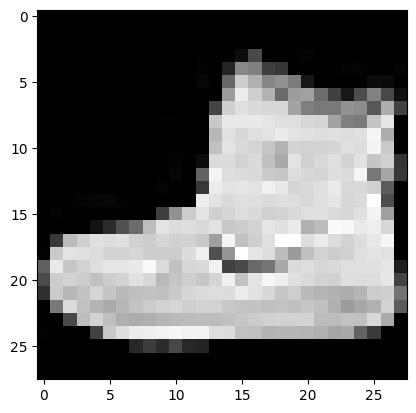

In [11]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [12]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

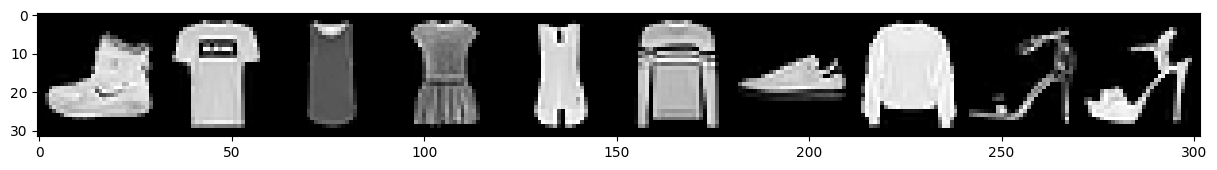

In [13]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [14]:
img_grid = torchvision.utils.make_grid(images)
writer.add_image("mnist_images",img_grid)
writer.close()

In [15]:
%load_ext tensorboard
%tensorboard --logdir runs

In [16]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out


In [17]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)
criterion = nn.CrossEntropyLoss()

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [18]:

writer.add_graph(model, images)
writer.close


/home/sadiaprome/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


<bound method SummaryWriter.close of <torch.utils.tensorboard.writer.SummaryWriter object at 0x7f661f2339d0>>

In [19]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 6292), started 0:00:01 ago. (Use '!kill 6292' to kill it.)

In [20]:
num_epochs = 5
count = 0
n_total_steps = len(train_loader)
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

    

Iteration: 500, Loss: 0.44865188002586365, Accuracy: 86.37999725341797%
Iteration: 1000, Loss: 0.3185808062553406, Accuracy: 87.86000061035156%
Iteration: 1500, Loss: 0.2729378640651703, Accuracy: 88.37999725341797%
Iteration: 2000, Loss: 0.23179565370082855, Accuracy: 88.81999969482422%
Iteration: 2500, Loss: 0.13877853751182556, Accuracy: 88.83000183105469%
Iteration: 3000, Loss: 0.17502182722091675, Accuracy: 89.62000274658203%


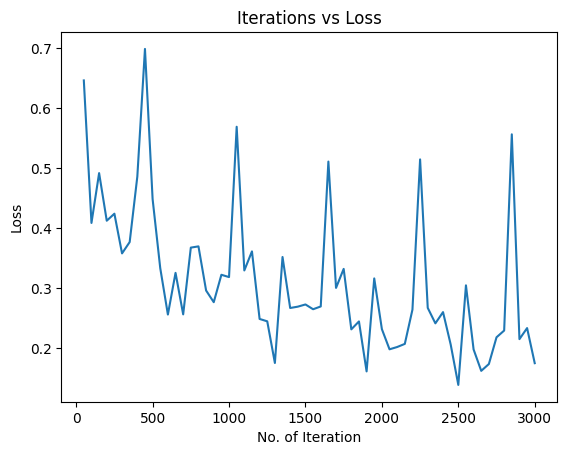

In [21]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

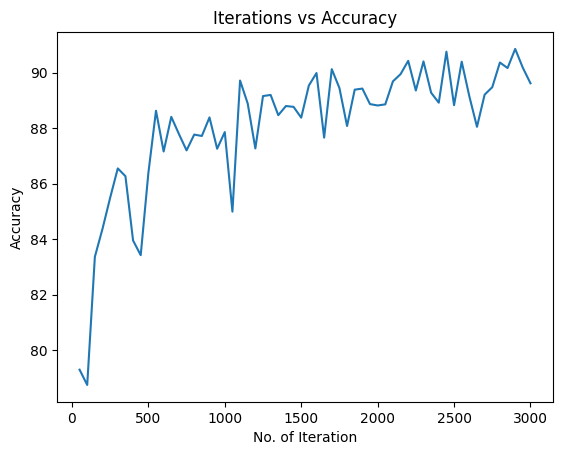

In [22]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [23]:
for epoch in range(5):
    total_train_loss = 0.0
    total_test_loss = 0.0
    
    print("Epoch:", epoch)
    model.train()
    
    total = 0
    for idx,(image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        
        pred = model(image)
        loss=criterion(pred, label)
        total_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        pred = torch.nn.functional.softmax(pred,dim=1)
        
        for i,p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total=total+1
                
        total_train_acc = total / len(train_set)
        total_train_loss = total_train_loss / (idx + 1)
        
        total = 0
        model.eval()
    for idx,(image, label) in enumerate(test_loader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss=criterion(pred, label)
        total_test_loss += loss.item()
        pred = torch.nn.functional.softmax(pred,dim=1)
                    
    for i,p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total=total+1 
                
            total_train_acc = total/ len(test_set) 
            total_train_loss = total_test_loss / (idx + 1)
                
                    

    if epoch %2==0:
        writer.add_scalar('Loss/Training',total_train_loss,epoch)
        writer.add_scalar('Loss/Testing',total_train_loss,epoch)
        writer.add_scalar('Accuracy/Training',total_train_acc,epoch)
        writer.add_scalar('Accuracy/Testing',total_train_acc,epoch)
        print("Epoch: ", epoch)
            


Epoch: 0
Epoch:  0
Epoch: 1
Epoch: 2
Epoch:  2
Epoch: 3
Epoch: 4
Epoch:  4


In [24]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 6292), started 0:26:59 ago. (Use '!kill 6292' to kill it.)